# <span style='color:red'>Project 4.  Due December 1</span>

In this project we develop an updated first-order algorithm to construct a portfolio using intraday data; now with position bounds and using projected gradients.

In [15]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import itertools
import math

##### We will have data involving $n$ assets, and use the first $T$ days of the data to compute the portfolio.
##### The computation will produce a weight $x_i$ for each asset $i = 1,...,n$, which could be long or short.
##### We assume that on each day, a position is taken at the open, and closed at noon.  So we define:
$$ p^o_{j,t} = \ \text{price of asset $j$ on day $t$ at the open}$$
$$ p^1_{j,t} = \ \text{price of asset $j$ on day $t$ at noon}$$
$$ r_{j,t} =  \ \frac{p^1_{j,t} - p^o_{j,t}}{p^o_{j,t}} = \ \text{return earned by asset $j$ on day $t$.}$$
$$ \bar r_j = \ \frac{1}{T} \sum_{t = 1}^T r_{j,t} = \ \text{average return earned by asset $j$.}$$

The assets that we will use are: ABR, AMZN, GS, NFLX, NIO, NVDA, TSLA, UBS.

#### The optimization problem to solve depends on two parameters: $\theta \ge 0$ and $\pi > 0$.

$$\begin{align*}
\text{minimize} & \ \left(-\sum_{j = 1}^n \bar r_j x_j\right) + \theta \left( \frac{1}{T} \sum_{t = 1}^{T}\left[\sum_{j = 1}^n (r_{j,t} -  \bar r_j)x_j\right]^\pi\right) \\

\text{subject to} & \ |x_j| \le 1 \ \text{for all names $j$} \\
\end{align*}$$

#### Unlike what we did on project $2$, the risk term is **not** raised to the power $1/\pi$.

### Derivation of the Gradient

1. **First Term Derivative (g)**:
   - The derivative of the first term is the same as in Project 2:
     $$ \frac{dg}{dx_k} \left(-\sum_{j = 1}^n \bar r_j x_j\right) = -\bar r_k $$

2. **Second Term Derivative (h)**:
   - This term is different from Project 2 as the risk term is not raised to the power $\frac{1}{\pi}$. The derivative is:
     $$ \frac{dh}{dx_k} = \theta \cdot \frac{1}{T} \sum_{t = 1}^{T} \pi \left[\sum_{j = 1}^n (r_{j,t} - \bar r_j)x_j\right]^{\pi-1} \cdot (r_{k,t} - \bar r_k) $$

3. **Sum of Derivatives**:
   - Combining the two:
     $$ \frac{\partial F(x)}{\partial x_k} = -\bar r_k + \theta \cdot \frac{1}{T} \sum_{t = 1}^{T} \pi\left[\sum_{j = 1}^n (r_{j,t} - \bar r_j)x_j\right]^{\pi-1} \cdot (r_{k,t} - \bar r_k) $$

### Incorporating the Constraint

With the constraint $|x_j| \le 1$, we need to use a projected gradient method. After each gradient step, we need to project the solution back into the feasible region by ensuring that each component of $x$ satisfies the constraint. This can be done by simply clipping each component of $x$ so that it falls within [-1, 1].

In [16]:
# read in data
train = pd.read_csv('./data/combined.csv', index_col=0)
# computing the mean return for every ticker
r_bar = train.mean(axis=0).values
print('r_bar shape:', r_bar.shape)
# computing the difference between return at time=t and for stock=i and mean return
r_diff = train.subtract(r_bar).values
print('r_diff shape:', r_diff.shape)

r_bar shape: (8,)
r_diff shape: (93, 8)


In [17]:
def func(x: np.ndarray, r_bar: np.ndarray, r_diff: np.ndarray, theta: float, pi: float, T: int) -> np.ndarray:
    '''Vectorized function to minimize.'''
    return -np.dot(r_bar, x) + theta/T * np.linalg.norm(r_diff @ x, pi)**pi

def grad(x: np.ndarray, r_bar: np.ndarray, r_diff: np.ndarray, theta: float, pi: float, T: int) -> np.ndarray:
    '''Vectorized gradient of function to minimize.'''
    r_diff_at_x = r_diff @ x
    temp = (theta/T*pi) * ((r_diff_at_x**(pi-1)).T @ r_diff)
    return -r_bar + temp

### <span style='color:red'> Develop a first-order method to address this computational problem.</span>

#### Your method should work with values of $T$ at least $100$.

#### Make sure your code works with $\pi = 2$ and $\pi = 4$.  For $\pi = 2$ use $\theta = 5$. You should be able to get meaningful problem behavior (i.e., nonzero portfolio).  And when $\pi = 4$ use $\theta = 1000$.
<br>

#### Suggestion: first apply the problem to one asset at a time, i.e., $n = 1$.  Then use $n = 2$.  And only then try the entire set of names.  And use $\pi = 2$ before trying $\pi = 4$.

In [18]:
def gradient_descent(r_bar: np.ndarray, r_diff: np.ndarray, \
                     theta: float, pi: float, x_0: float, alpha: float, beta: float, max_iter=1000, tolerance=1e-8) -> tuple:
    '''Gradient descent function for the constrained problem.'''
    converged = False
    T = r_diff.shape[0]
    x = y = x_0
    # evaluating function at initial value
    # seeing if we can minimize this!
    f = func(x=x, r_bar=r_bar, r_diff=r_diff, theta=theta, pi=pi, T=T)
    hist = [f]
    
    for _ in range(max_iter):
        # computing gradient
        grad_ = grad(x=x, r_bar=r_bar, r_diff=r_diff, theta=theta, pi=pi, T=T)
        # norming gradient: why?
        #   1) we are able to control the step-size purely with beta and 
        #       alpha without being influenced by varying magnitude of gradient
        #   2) we are able to eliminate "slow crawling" gradient descent and
        #       push out of flat regions of the surface faster
        grad_ /= np.linalg.norm(grad_)
        # computing next step using momentum
        y = beta*y + (1-beta)*grad_
        # clipping the gradient to enforce the problem's constraint
        x = np.clip(x - alpha*y, -1, 1)
        # evaluating new function value
        f_new = func(x=x, r_bar=r_bar, r_diff=r_diff, theta=theta, pi=pi, T=T)
        hist.append(f_new)
        # checking convergence
        if f - f_new < tolerance:
            converged = True
            break
        # new function value is the old function value in the next iteration
        f = f_new
        
    # returning tuple of
    #   bool: did we converge?
    #   np.ndarray: our portfolio positions at optimality
    #   list: function value at each step of gradient descent
    return converged, x, hist

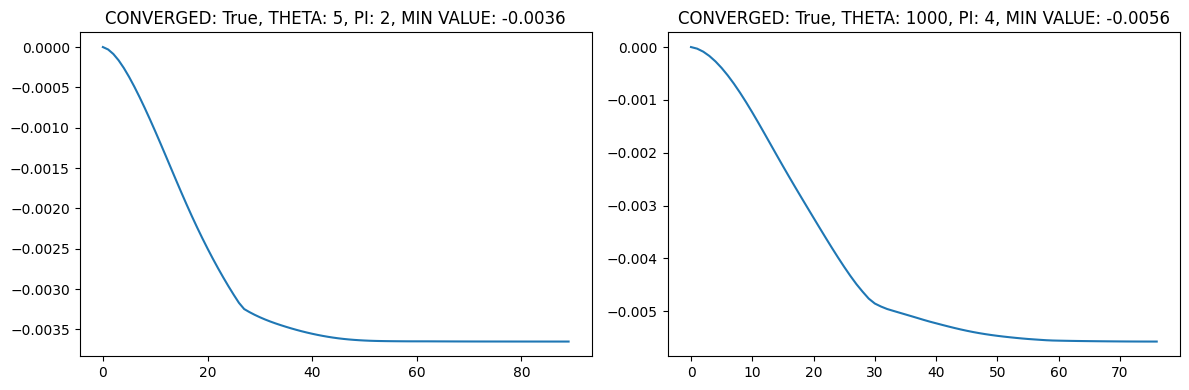

In [19]:
params = dict(
    # our initial guess as to the optimal portfolio
    x_0=np.array([0]*8),
    alpha=1e-1, beta=0.90, # alpha is learning rate, beta is momentum parameter
    # we will run gradient descent for 500 iterations max
    # and consider a difference between new and old value of <= 1e-8 as having converged!
    max_iter=500, tolerance=1e-8
)

data = dict()
for theta, pi in zip([5, 1000], [2, 4]):
    # **params unpacks dictionary keys and values and uses the keys as function parameters
    # and the values as parameter values
    data[ (theta, pi) ] = gradient_descent(r_bar=r_bar, r_diff=r_diff, theta=theta, pi=pi, **params)

ncol = 2
nrow = math.ceil(len(data) / ncol)
figure, axes = plt.subplots(nrow, ncol, figsize=(12, 4))

# itertools.zip_longest pads the shorter iterable with None type to avoid loop issues
for ax, ((theta, pi), (converged, x, hist)) in itertools.zip_longest(axes.flat, data.items()):
    if ax is not None:
        ax.set_title(f"CONVERGED: {converged}, THETA: {theta}, PI: {pi}, MIN VALUE: {round(hist[-1], 4)}")
    
        sns.lineplot(data=hist, ax=ax)
    
    else:
        # we delete unneeded axes on the figure because we have 
        # fewer theta/pi combinations than axes
        figure.delaxes(ax)

plt.tight_layout() # decreasing the padding and margin on the figure
plt.show()

### <span style='color:red'>**Extra credit**</span>
#### Suppose $x^*$ is the solution you compute above.  Next, solve the same optimization problem as above, except that you now have the constraint:
$$ \sum_j | x_j | \ \le \ 0.5*\sum_j |x^*_j |$$

Use a first-order barrier method, as covered in class, for this purpose.

### Please be sure to have completed all other parts of this project before trying this part.  "Extra credit" = only valid if other parts have been done.

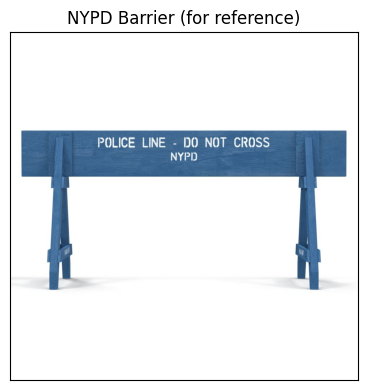

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.imshow(mpimg.imread('./data/barrier.jpg'))
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('NYPD Barrier (for reference)')

plt.tight_layout()
plt.show()

In [21]:
# using portfolio from theta=0.5 and pi=2
x_star = data[(5, 2)][1]
# upper bound for the sum of absolute value of positions
# calling this gamma in the formulation below
sum_abs_ub = 0.5 * np.sum( np.abs( x_star ) )
print(sum_abs_ub)

3.33949607728309


In [22]:
# initial guesses for the EC problem
x_0 = np.array([0]*8)
y_0 = x_0 + 0.0005

# feasibility checks (should all evaluate to True)
print( all( np.abs(x_0) <= 1 ) )
print( np.sum(y_0) <= sum_abs_ub )
print( all(y_0 >= x_0) )
print( all(y_0 >= -x_0) )

True
True
True
True


$$\begin{align*}
\text{minimize} & \ \left(-\sum_{j = 1}^n \bar r_j x_j\right) + \theta \left( \frac{1}{T} \sum_{t = 1}^{T}\left[\sum_{j = 1}^n (r_{j,t} -  \bar r_j)x_j\right]^\pi\right) + \mu B(x, y) \\

\text{subject to} & \ |x_j| \le 1 \ \text{for all names $j$} \\
                  & e'y \leq \gamma \\
                  & y_i \geq x_i \ \text{for all $i$} \\
                  & y_i \geq -x_i \ \text{for all $i$}  \\
\end{align*}$$

The new gradient function becomes:

$$
\begin{aligned}
\nabla F(x,y) &= -\bar r_k + \theta \cdot \frac{1}{T} \sum_{t = 1}^{T} \pi\left[\sum_{j = 1}^n (r_{j,t} - \bar r_j)x_j\right]^{\pi-1} \cdot (r_{k,t} - \bar r_k) + \nabla B(x, y) \\
\frac{\partial F(x, y)}{\partial x_k} &= -\bar r_k + \theta \cdot \frac{1}{T} \sum_{t = 1}^{T} \pi\left[\sum_{j = 1}^n (r_{j,t} - \bar r_j)x_j\right]^{\pi-1} \cdot (r_{k,t} - \bar r_k) + \mu \sum_{j = 1}^n \frac{1}{y_i - x_i} - \frac{1}{y_i + x_i}\\
\frac{\partial F(x, y)}{\partial y_k} &= \mu \left( \frac{1}{\gamma - \text{1}^Ty} - \frac{1}{y - x} - \frac{1}{y + x} \right)
\end{aligned}
$$

In [23]:
def func_bar(x: np.ndarray, y: np.ndarray, r_bar: np.ndarray, r_diff: np.ndarray, gamma: float, \
              theta: float, pi: float, T: int, mu: float) -> np.ndarray:
    '''Vectorized function to minimize BUT MAKE IT BARRIER STYLE.'''
    f = -np.dot(r_bar, x) + theta/T * np.linalg.norm(r_diff @ x, pi)**pi
    bar = -mu * ( np.log(gamma - np.sum(y) ) + np.sum( np.log( y - x ) ) + np.sum( np.log( y + x ) ) )
    return f + bar

def grad_bar(x: np.ndarray, y: np.ndarray, r_bar: np.ndarray, r_diff: np.ndarray, gamma: float, \
              theta: float, pi: float, T: int, mu: float) -> np.ndarray:
    '''Vectorized gradient of function to minimize BUT MAKE IT BARRIER STYLE. Need to consider x AND y!'''
    r_diff_at_x = r_diff @ x
    x_orig = -r_bar + (theta/T*pi) * ((r_diff_at_x**(pi-1)).T @ r_diff)
    x_new = x_orig + mu*( 1/(y-x) - (1/(y+x)) )
    
    y_new = mu*(1/(gamma - np.sum(y))*np.ones(y.shape).T - 1/(y-x) - 1/(y+x))

    return x_new, y_new

In [24]:
def gradient_descent_bar(r_bar: np.ndarray, r_diff: np.ndarray, \
                    gamma: float, theta: float, pi: float, mu: float, x_0: float, y_0: float, \
                    alpha: float, beta: float, max_iter=1000, tolerance=1e-8) -> tuple:
    '''Gradient descent function for the constrained problem BUT MAKE IT BARRIER STYLE.'''
    converged = False
    T = r_diff.shape[0]
    x = x1 = x_0
    y = y1 = y_0
    # evaluating function at initial value
    # seeing if we can minimize this!
    f = func_bar(x, y, r_bar, r_diff, gamma, theta, pi, T, mu)
    hist = [f]
    
    for _ in range(max_iter):
        # computing gradient
        grad_x, grad_y = grad_bar(x, y, r_bar, r_diff, gamma, theta, pi, T, mu)
        # norming gradient: why?
        #   1) we are able to control the step-size purely with beta and 
        #       alpha without being influenced by varying magnitude of gradient
        #   2) we are able to eliminate "slow crawling" gradient descent and
        #       push out of flat regions of the surface faster
        grad_x /= np.linalg.norm(grad_x)
        grad_y /= np.linalg.norm(grad_y)
        # computing next step using momentum
        x1 = beta*x1 + (1-beta)*grad_x
        y1 = beta*y1 + (1-beta)*grad_y
        # clipping the gradient to enforce the problem's constraint
        x = np.clip(x - alpha*x1, -1, 1) # only the x is clipped to enforce constraint
        y = y - alpha*y1
        # evaluating new function value
        f_new = func_bar(x, y, r_bar, r_diff, gamma, theta, pi, T, mu)
        hist.append(f_new)
        # checking convergence
        # if f - f_new < tolerance:
        if np.linalg.norm(grad_x) < tolerance and np.linalg.norm(grad_y) < tolerance:
            converged = True
            break
        # new function value is the old function value in the next iteration
        f = f_new
        
    # returning tuple of
    #   bool: did we converge?
    #   np.ndarray: our portfolio positions at optimality
    #   list: function value at each step of gradient descent
    return converged, x, y, hist

In [25]:
params = dict(
    # our initial guess as to the optimal portfolio
    x_0=x_0,
    y_0=y_0,
    gamma=sum_abs_ub, mu=1e-2, # gamma is a constant, mu is a parameter controlling the barrier
    alpha=1e-3, beta=0.90, # alpha is learning rate, beta is momentum parameter
    # we will run gradient descent for 500 iterations max
    # and consider a difference between new and old value of <= 1e-8 as having converged!
    max_iter=500, tolerance=1e-8
)

theta, pi = 5, 2
converged, x, y, hist = gradient_descent_bar(r_bar=r_bar, r_diff=r_diff, theta=theta, pi=pi, **params)
# did we converge?
print(f'Converged: {converged}')

Converged: False


In [26]:
# our final portfolio
print(f'x: {x}')
print(f'y: {y}')
# final objective value without log barrier
print(f'Objective value (no barrier): {func(x=x, r_bar=r_bar, r_diff=r_diff, theta=theta, pi=pi, T=r_diff.shape[0])}')

x: [ 0.00192088  0.00042787  0.00165296 -0.00062556  0.00153414 -0.00082287
 -0.00080513 -0.00305372]
y: [0.17409233 0.17408684 0.17409045 0.17408721 0.17408988 0.17408761
 0.17408759 0.17409975]
Objective value (no barrier): -1.3441835437764382e-05


In [27]:
# final feasibility checks (should all evaluate to True)
print( all( np.abs(x) <= 1 ) )
print( np.sum(y) <= sum_abs_ub )
print( all(y >= x) )
print( all(y >= -x) )

True
True
True
True
